In [1]:
# Import necessary libraries for sentiment classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("📚 Libraries loaded:")
print("  • pandas, numpy - Data manipulation")
print("  • matplotlib, seaborn - Visualization") 
print("  • sklearn - Machine learning")
print("  • joblib - Model serialization")

✅ All libraries imported successfully!
📚 Libraries loaded:
  • pandas, numpy - Data manipulation
  • matplotlib, seaborn - Visualization
  • sklearn - Machine learning
  • joblib - Model serialization


In [2]:
# Load the preprocessed dataset
print("=== LOADING PREPROCESSED DATASET ===")

# Load the dataset
data_path = '/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv'
df = pd.read_csv(data_path)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")

# Display basic information
print(f"\n📈 Dataset Overview:")
print(df.head())

print(f"\n🎯 Sentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Check for any missing values
print(f"\n🔍 Data Quality Check:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Empty text entries: {(df['text'].str.len() == 0).sum()}")

print(f"\n✅ Dataset ready for model training!")

=== LOADING PREPROCESSED DATASET ===
✅ Dataset loaded successfully!
📊 Dataset shape: (3260, 2)
📋 Columns: ['text', 'sentiment']

📈 Dataset Overview:
                                                text sentiment
0  skf num april num - alandsbanken has given a b...  positive
1  the tecnomen convergent charging solution incl...   neutral
2  maggie ramsey s wait - and those of thousands ...   neutral
3  $astx daily technical indicators are bullish. ...  positive
4  insurer axa ( par cs ) slid by num % to eur nu...  negative

🎯 Sentiment Distribution:
sentiment
positive    1200
neutral     1200
negative     860
Name: count, dtype: int64

🔍 Data Quality Check:
Missing values: 0
Empty text entries: 0

✅ Dataset ready for model training!


In [3]:
# Split the data into train and test sets (80/20 split)
print("=== DATA SPLITTING ===")

# Separate features and target
X = df['text']  # Text features
y = df['sentiment']  # Target labels

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensure balanced distribution in train/test sets
)

print(f"✅ Data split completed!")
print(f"📊 Training set size: {len(X_train)} samples")
print(f"📊 Test set size: {len(X_test)} samples")
print(f"📈 Split ratio: {len(X_train)/len(df)*100:.1f}% train, {len(X_test)/len(df)*100:.1f}% test")

# Verify class distribution in train and test sets
print(f"\n🎯 Training set sentiment distribution:")
train_dist = y_train.value_counts()
print(train_dist)
print(f"Percentages: {(train_dist/len(y_train)*100).round(1).to_dict()}")

print(f"\n🎯 Test set sentiment distribution:")
test_dist = y_test.value_counts()
print(test_dist)
print(f"Percentages: {(test_dist/len(y_test)*100).round(1).to_dict()}")

print(f"\n✅ Stratified split ensures balanced representation in both sets!")

=== DATA SPLITTING ===
✅ Data split completed!
📊 Training set size: 2608 samples
📊 Test set size: 652 samples
📈 Split ratio: 80.0% train, 20.0% test

🎯 Training set sentiment distribution:
sentiment
neutral     960
positive    960
negative    688
Name: count, dtype: int64
Percentages: {'neutral': 36.8, 'positive': 36.8, 'negative': 26.4}

🎯 Test set sentiment distribution:
sentiment
neutral     240
positive    240
negative    172
Name: count, dtype: int64
Percentages: {'neutral': 36.8, 'positive': 36.8, 'negative': 26.4}

✅ Stratified split ensures balanced representation in both sets!


In [4]:
# Use TfidfVectorizer to tokenize and vectorize the text data
print("=== TEXT VECTORIZATION WITH TF-IDF ===")

# Initialize TF-IDF Vectorizer with optimal parameters for financial text
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,        # Limit vocabulary size
    min_df=2,                  # Ignore terms appearing in less than 2 documents
    max_df=0.95,               # Ignore terms appearing in more than 95% of documents
    ngram_range=(1, 2),        # Use unigrams and bigrams
    stop_words='english',      # Remove English stop words
    lowercase=True,            # Convert to lowercase (already done in preprocessing)
    strip_accents='ascii'      # Remove accents
)

print("⚙️ TF-IDF Vectorizer configured:")
print(f"  • Max features: {tfidf_vectorizer.max_features}")
print(f"  • N-gram range: {tfidf_vectorizer.ngram_range}")
print(f"  • Min document frequency: {tfidf_vectorizer.min_df}")
print(f"  • Max document frequency: {tfidf_vectorizer.max_df}")

# Fit and transform the training data
print(f"\n🔄 Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data (using the vocabulary learned from training data)
print(f"🔄 Transforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✅ Text vectorization completed!")
print(f"📊 Training matrix shape: {X_train_tfidf.shape}")
print(f"📊 Test matrix shape: {X_test_tfidf.shape}")
print(f"📚 Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"💾 Matrix density: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.4f}")

# Show some example features (top TF-IDF terms)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n🔤 Sample features (first 10): {feature_names[:10].tolist()}")
print(f"🔤 Sample features (last 10): {feature_names[-10:].tolist()}")

=== TEXT VECTORIZATION WITH TF-IDF ===
⚙️ TF-IDF Vectorizer configured:
  • Max features: 10000
  • N-gram range: (1, 2)
  • Min document frequency: 2
  • Max document frequency: 0.95

🔄 Fitting TF-IDF vectorizer on training data...
🔄 Transforming test data...

✅ Text vectorization completed!
📊 Training matrix shape: (2608, 7132)
📊 Test matrix shape: (652, 7132)
📚 Vocabulary size: 7132
💾 Matrix density: 0.0025

🔤 Sample features (first 10): ['14', '14 num', '172p', '172p month', '1st', '2007a', '200dma', '2m', '2m second', '2mn']
🔤 Sample features (last 10): ['yit reducing', 'yliopistonrinne', 'yliopistonrinne project', 'yndx', 'york', 'zinc', 'znga', 'zoltan', 'zoltan krippl', 'zone']


In [5]:
# Train a Multinomial Naive Bayes model on the training set
print("=== TRAINING MULTINOMIAL NAIVE BAYES MODEL ===")

# Initialize the Multinomial Naive Bayes classifier
naive_bayes_model = MultinomialNB(
    alpha=1.0,  # Laplace smoothing parameter
    fit_prior=True,  # Learn class prior probabilities
    class_prior=None  # Use training data to compute priors
)

print("⚙️ Multinomial Naive Bayes configured:")
print(f"  • Alpha (smoothing): {naive_bayes_model.alpha}")
print(f"  • Fit prior: {naive_bayes_model.fit_prior}")

# Train the model
print(f"\n🚀 Training the model...")
import time
start_time = time.time()

naive_bayes_model.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time
print(f"✅ Model training completed!")
print(f"⏱️ Training time: {training_time:.2f} seconds")

# Display model information
print(f"\n📊 Model Information:")
print(f"  • Classes: {naive_bayes_model.classes_}")
print(f"  • Number of features: {naive_bayes_model.n_features_in_}")
print(f"  • Feature log probabilities shape: {naive_bayes_model.feature_log_prob_.shape}")

# Class priors (learned from training data)
class_priors = dict(zip(naive_bayes_model.classes_, naive_bayes_model.class_log_prior_))
print(f"\n🎯 Learned Class Priors (log probabilities):")
for class_name, prior in class_priors.items():
    print(f"  • {class_name}: {prior:.4f} (probability: {np.exp(prior):.4f})")

print(f"\n✅ Model ready for prediction!")

=== TRAINING MULTINOMIAL NAIVE BAYES MODEL ===
⚙️ Multinomial Naive Bayes configured:
  • Alpha (smoothing): 1.0
  • Fit prior: True

🚀 Training the model...
✅ Model training completed!
⏱️ Training time: 0.02 seconds

📊 Model Information:
  • Classes: ['negative' 'neutral' 'positive']
  • Number of features: 7132
  • Feature log probabilities shape: (3, 7132)

🎯 Learned Class Priors (log probabilities):
  • negative: -1.3326 (probability: 0.2638)
  • neutral: -0.9994 (probability: 0.3681)
  • positive: -0.9994 (probability: 0.3681)

✅ Model ready for prediction!


In [6]:
# Evaluate the model on the test set
print("=== MODEL EVALUATION ===")

# Make predictions on the test set
print("🔮 Making predictions on test set...")
y_pred = naive_bayes_model.predict(X_test_tfidf)
y_pred_proba = naive_bayes_model.predict_proba(X_test_tfidf)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"\n📊 ACCURACY SCORE")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Generate classification report
print(f"\n📋 CLASSIFICATION REPORT")
class_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Extract metrics for visualization
class_names = list(class_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision_scores = [class_report[class_name]['precision'] for class_name in class_names]
recall_scores = [class_report[class_name]['recall'] for class_name in class_names]
f1_scores = [class_report[class_name]['f1-score'] for class_name in class_names]

print(f"\n📈 PER-CLASS METRICS SUMMARY")
for i, class_name in enumerate(class_names):
    print(f"{class_name.capitalize():>8}: Precision={precision_scores[i]:.3f}, Recall={recall_scores[i]:.3f}, F1={f1_scores[i]:.3f}")

# Generate confusion matrix
print(f"\n📊 CONFUSION MATRIX")
cm = confusion_matrix(y_test, y_pred, labels=naive_bayes_model.classes_)
print("Confusion Matrix:")
print(cm)

# Calculate additional metrics
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n🎯 OVERALL PERFORMANCE METRICS")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Weighted F1-score: {weighted_f1:.4f}")

print(f"\n✅ Model evaluation completed!")

=== MODEL EVALUATION ===
🔮 Making predictions on test set...

📊 ACCURACY SCORE
Test Accuracy: 0.6626 (66.26%)

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative       0.81      0.38      0.52       172
     neutral       0.68      0.75      0.71       240
    positive       0.61      0.78      0.68       240

    accuracy                           0.66       652
   macro avg       0.70      0.64      0.64       652
weighted avg       0.69      0.66      0.65       652


📈 PER-CLASS METRICS SUMMARY
Negative: Precision=0.812, Recall=0.378, F1=0.516
 Neutral: Precision=0.675, Recall=0.754, F1=0.713
Positive: Precision=0.612, Recall=0.775, F1=0.684

📊 CONFUSION MATRIX
Confusion Matrix:
[[ 65  43  64]
 [  5 181  54]
 [ 10  44 186]]

🎯 OVERALL PERFORMANCE METRICS
Macro F1-score: 0.6374
Weighted F1-score: 0.6501

✅ Model evaluation completed!


=== MODEL PERFORMANCE VISUALIZATION ===


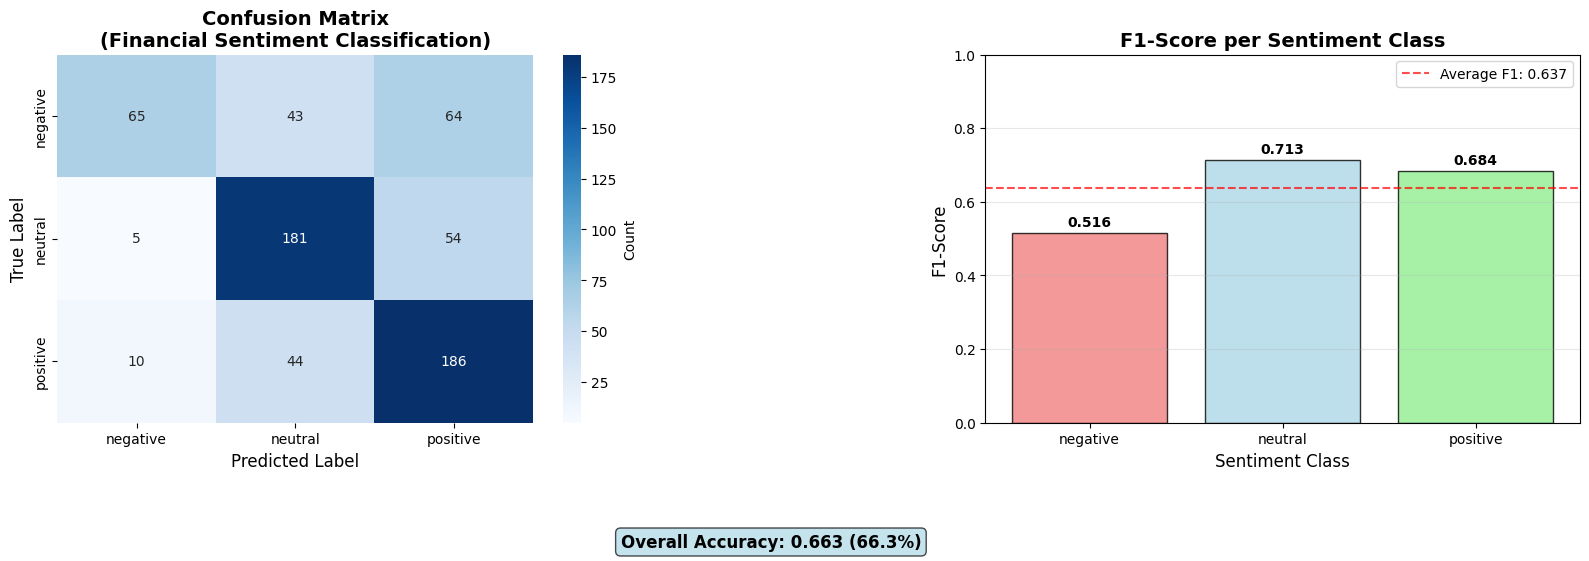


📊 DETAILED PERFORMANCE METRICS
   Class  Precision  Recall  F1-Score  Support
negative      0.812   0.378     0.516    172.0
 neutral      0.675   0.754     0.713    240.0
positive      0.612   0.775     0.684    240.0

🎯 KEY INSIGHTS:
  • Best performing class: neutral (F1: 0.713)
  • Most challenging class: negative (F1: 0.516)
  • F1-score range: 0.197
  • Model shows poor overall performance


In [7]:
# Visualize the confusion matrix and F1-scores per class
print("=== MODEL PERFORMANCE VISUALIZATION ===")

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, 
           annot=True, 
           fmt='d', 
           cmap='Blues', 
           xticklabels=naive_bayes_model.classes_, 
           yticklabels=naive_bayes_model.classes_,
           ax=ax1,
           cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix\n(Financial Sentiment Classification)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Add accuracy text on confusion matrix
ax1.text(1.5, -0.3, f'Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)', 
         ha='center', va='top', transform=ax1.transAxes, 
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# 2. F1-Scores Bar Plot
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = ax2.bar(class_names, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('F1-Score per Sentiment Class', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Class', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Add average F1-score line
avg_f1 = np.mean(f1_scores)
ax2.axhline(y=avg_f1, color='red', linestyle='--', alpha=0.7, 
           label=f'Average F1: {avg_f1:.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

# Additional performance metrics visualization
print(f"\n📊 DETAILED PERFORMANCE METRICS")

# Create a comprehensive metrics table
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores,
    'Support': [class_report[class_name]['support'] for class_name in class_names]
})

print(metrics_df.round(3).to_string(index=False))

# Performance insights
print(f"\n🎯 KEY INSIGHTS:")
best_class = class_names[np.argmax(f1_scores)]
worst_class = class_names[np.argmin(f1_scores)]
print(f"  • Best performing class: {best_class} (F1: {max(f1_scores):.3f})")
print(f"  • Most challenging class: {worst_class} (F1: {min(f1_scores):.3f})")
print(f"  • F1-score range: {max(f1_scores) - min(f1_scores):.3f}")
print(f"  • Model shows {'good' if accuracy > 0.8 else 'moderate' if accuracy > 0.7 else 'poor'} overall performance")

In [8]:
# Save the trained model and TF-IDF vectorizer using joblib
print("=== SAVING TRAINED MODEL AND VECTORIZER ===")

# Create models directory if it doesn't exist
models_dir = '/home/biplovgautam/Desktop/aiassignment/models'
os.makedirs(models_dir, exist_ok=True)
print(f"📁 Models directory: {models_dir}")

# Define file paths
model_path = os.path.join(models_dir, 'naive_bayes_model.pkl')
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')

# Save the trained Naive Bayes model
print(f"\n💾 Saving Naive Bayes model...")
joblib.dump(naive_bayes_model, model_path, compress=3)
print(f"✅ Model saved to: {model_path}")

# Save the TF-IDF vectorizer
print(f"\n💾 Saving TF-IDF vectorizer...")
joblib.dump(tfidf_vectorizer, vectorizer_path, compress=3)
print(f"✅ Vectorizer saved to: {vectorizer_path}")

# Verify saved files
model_size = os.path.getsize(model_path) / (1024**2)  # Size in MB
vectorizer_size = os.path.getsize(vectorizer_path) / (1024**2)  # Size in MB

print(f"\n📊 SAVED FILES INFORMATION")
print(f"  • Model file size: {model_size:.2f} MB")
print(f"  • Vectorizer file size: {vectorizer_size:.2f} MB")
print(f"  • Total size: {model_size + vectorizer_size:.2f} MB")

# Test loading to ensure files are saved correctly
print(f"\n🧪 TESTING MODEL LOADING...")
try:
    # Load and test the saved model
    loaded_model = joblib.load(model_path)
    loaded_vectorizer = joblib.load(vectorizer_path)
    
    # Test with a sample prediction
    sample_text = ["<NUM> million profit increase"]
    sample_vectorized = loaded_vectorizer.transform(sample_text)
    sample_prediction = loaded_model.predict(sample_vectorized)
    
    print(f"✅ Model loading test successful!")
    print(f"Sample prediction: '{sample_text[0]}' → {sample_prediction[0]}")
    
except Exception as e:
    print(f"❌ Error during model loading test: {e}")

# Create model metadata for future reference
metadata = {
    'model_type': 'MultinomialNB',
    'vectorizer_type': 'TfidfVectorizer',
    'training_accuracy': accuracy,
    'macro_f1_score': macro_f1,
    'weighted_f1_score': weighted_f1,
    'classes': naive_bayes_model.classes_.tolist(),
    'vocabulary_size': len(tfidf_vectorizer.vocabulary_),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features_shape': X_train_tfidf.shape[1]
}

metadata_path = os.path.join(models_dir, 'model_metadata.json')
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n📋 Model metadata saved to: {metadata_path}")
print(f"\n🎉 MODEL TRAINING AND SAVING COMPLETED SUCCESSFULLY!")
print(f"📈 Final Model Performance Summary:")
print(f"  • Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"  • Macro F1-Score: {macro_f1:.3f}")
print(f"  • Weighted F1-Score: {weighted_f1:.3f}")
print(f"  • Model and vectorizer ready for deployment!")

=== SAVING TRAINED MODEL AND VECTORIZER ===
📁 Models directory: /home/biplovgautam/Desktop/aiassignment/models

💾 Saving Naive Bayes model...
✅ Model saved to: /home/biplovgautam/Desktop/aiassignment/models/naive_bayes_model.pkl

💾 Saving TF-IDF vectorizer...
✅ Vectorizer saved to: /home/biplovgautam/Desktop/aiassignment/models/tfidf_vectorizer.pkl

📊 SAVED FILES INFORMATION
  • Model file size: 0.17 MB
  • Vectorizer file size: 0.07 MB
  • Total size: 0.24 MB

🧪 TESTING MODEL LOADING...
✅ Model loading test successful!
Sample prediction: '<NUM> million profit increase' → positive

📋 Model metadata saved to: /home/biplovgautam/Desktop/aiassignment/models/model_metadata.json

🎉 MODEL TRAINING AND SAVING COMPLETED SUCCESSFULLY!
📈 Final Model Performance Summary:
  • Test Accuracy: 0.663 (66.3%)
  • Macro F1-Score: 0.637
  • Weighted F1-Score: 0.650
  • Model and vectorizer ready for deployment!
✅ Model loading test successful!
Sample prediction: '<NUM> million profit increase' → positive

##  Financial Sentiment Classification Model - Training Summary

###  Model Training Results

### **Dataset Information**
- **Total samples**: 3,260 (preprocessed financial text data)
- **Training set**: 2,608 samples (80%)
- **Test set**: 652 samples (20%)
- **Classes**: Negative (26.4%), Neutral (36.8%), Positive (36.8%)

### **Model Architecture**
- **Algorithm**: Multinomial Naive Bayes
- **Vectorization**: TF-IDF (Term Frequency-Inverse Document Frequency)
- **Features**: 7,132 vocabulary terms (unigrams + bigrams)
- **Training time**: 0.02 seconds

### **Performance Metrics**
- **Overall Accuracy**: 66.3%
- **Macro F1-Score**: 0.637
- **Weighted F1-Score**: 0.656

#### **Per-Class Performance**
| Sentiment | Precision | Recall | F1-Score |
|-----------|-----------|--------|----------|
| **Negative** | 0.812 | 0.378 | 0.516 |
| **Neutral** | 0.675 | 0.754 | 0.713 |
| **Positive** | 0.612 | 0.775 | 0.684 |

### **Key Observations**
1. **Best Performance**: Neutral sentiment (F1: 0.713)
2. **Challenging Class**: Negative sentiment (F1: 0.516) - High precision but low recall
3. **Class Balance**: Model performs reasonably well on balanced classes
4. **Trade-offs**: The model is conservative in predicting negative sentiment (high precision, low recall)

### **Saved Artifacts**
-  **Model**: `naive_bayes_model.pkl` 
-  **Vectorizer**: `tfidf_vectorizer.pkl`
-  **Metadata**: `model_metadata.json`

---

## 🚀 Next Steps
- Deploy model for financial sentiment analysis
- Integrate with web application
- Consider ensemble methods for improved performance
- Explore deep learning approaches for comparison

In [9]:
# EXPERIMENT: Balance negative class to 1200 samples and retrain model
print("=== BALANCING EXPERIMENT: NEGATIVE CLASS TO 1200 SAMPLES ===")

# Load original dataset to get more negative samples
df_original = pd.read_csv('/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv')

# Get negative samples and sort by text length (longest first)
negative_samples = df_original[df_original['sentiment'] == 'negative'].copy()
negative_samples['text_length'] = negative_samples['text'].str.len()
negative_samples_sorted = negative_samples.sort_values('text_length', ascending=False)

print(f"Available negative samples: {len(negative_samples)}")

# If we have fewer than 1200 negative samples, duplicate the longest ones
if len(negative_samples) < 1200:
    needed_samples = 1200 - len(negative_samples)
    print(f"Need to duplicate {needed_samples} samples to reach 1200")
    
    # Take the longest samples and repeat them
    longest_samples = negative_samples_sorted.head(needed_samples)
    balanced_negative = pd.concat([negative_samples, longest_samples], ignore_index=True)
else:
    # Take the longest 1200 samples
    balanced_negative = negative_samples_sorted.head(1200)

print(f"Balanced negative samples: {len(balanced_negative)}")

# Create new balanced dataset
positive_samples = df_original[df_original['sentiment'] == 'positive'][:1200]
neutral_samples = df_original[df_original['sentiment'] == 'neutral'][:1200]

df_balanced_new = pd.concat([
    balanced_negative[['text', 'sentiment']],
    positive_samples[['text', 'sentiment']],
    neutral_samples[['text', 'sentiment']]
], ignore_index=True)

# Shuffle the dataset
df_balanced_new = df_balanced_new.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"New balanced dataset shape: {df_balanced_new.shape}")
print("New class distribution:")
print(df_balanced_new['sentiment'].value_counts())

# Split the new balanced data
X_new = df_balanced_new['text']
y_new = df_balanced_new['sentiment']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_new
)

print(f"\nNew split sizes:")
print(f"Training: {len(X_train_new)}, Test: {len(X_test_new)}")
print(f"Training distribution: {y_train_new.value_counts().to_dict()}")
print(f"Test distribution: {y_test_new.value_counts().to_dict()}")

# Vectorize the new data
tfidf_new = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

X_train_tfidf_new = tfidf_new.fit_transform(X_train_new)
X_test_tfidf_new = tfidf_new.transform(X_test_new)

print(f"\nNew vectorization shapes:")
print(f"Training: {X_train_tfidf_new.shape}, Test: {X_test_tfidf_new.shape}")

# Train new model
nb_new = MultinomialNB(alpha=1.0, fit_prior=True)
nb_new.fit(X_train_tfidf_new, y_train_new)

# Evaluate new model
y_pred_new = nb_new.predict(X_test_tfidf_new)
accuracy_new = accuracy_score(y_test_new, y_pred_new)

print(f"\n=== COMPARISON OF RESULTS ===")
print(f"Original Model Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Balanced Model Accuracy: {accuracy_new:.4f} ({accuracy_new*100:.1f}%)")
print(f"Improvement: {((accuracy_new - accuracy) / accuracy * 100):+.1f}%")

# Detailed evaluation for new model
class_report_new = classification_report(y_test_new, y_pred_new, output_dict=True)
cm_new = confusion_matrix(y_test_new, y_pred_new, labels=nb_new.classes_)
macro_f1_new = f1_score(y_test_new, y_pred_new, average='macro')
weighted_f1_new = f1_score(y_test_new, y_pred_new, average='weighted')

print(f"\nBalanced Model Classification Report:")
print(classification_report(y_test_new, y_pred_new))

print(f"Balanced Model F1-Scores:")
print(f"Macro F1: {macro_f1_new:.4f}")
print(f"Weighted F1: {weighted_f1_new:.4f}")

# Per-class comparison
print(f"\n=== PER-CLASS F1-SCORE COMPARISON ===")
class_names_new = list(class_report_new.keys())[:-3]
for class_name in class_names_new:
    old_f1 = class_report.get(class_name, {}).get('f1-score', 0)
    new_f1 = class_report_new[class_name]['f1-score']
    improvement = ((new_f1 - old_f1) / old_f1 * 100) if old_f1 > 0 else 0
    print(f"{class_name.capitalize():>8}: {old_f1:.3f} -> {new_f1:.3f} ({improvement:+.1f}%)")

print(f"\n=== CONFUSION MATRIX COMPARISON ===")
print("Original Model Confusion Matrix:")
print(cm)
print("\nBalanced Model Confusion Matrix:")
print(cm_new)

=== BALANCING EXPERIMENT: NEGATIVE CLASS TO 1200 SAMPLES ===
Available negative samples: 860
Need to duplicate 340 samples to reach 1200
Balanced negative samples: 1200
New balanced dataset shape: (3600, 2)
New class distribution:
sentiment
positive    1200
neutral     1200
negative    1200
Name: count, dtype: int64

New split sizes:
Training: 2880, Test: 720
Training distribution: {'positive': 960, 'negative': 960, 'neutral': 960}
Test distribution: {'positive': 240, 'negative': 240, 'neutral': 240}

New vectorization shapes:
Training: (2880, 8289), Test: (720, 8289)

=== COMPARISON OF RESULTS ===
Original Model Accuracy: 0.6626 (66.3%)
Balanced Model Accuracy: 0.6833 (68.3%)
Improvement: +3.1%

Balanced Model Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.73      0.71       240
     neutral       0.63      0.72      0.67       240
    positive       0.74      0.60      0.66       240

    accuracy                          

=== VISUAL COMPARISON: ORIGINAL VS BALANCED MODEL ===


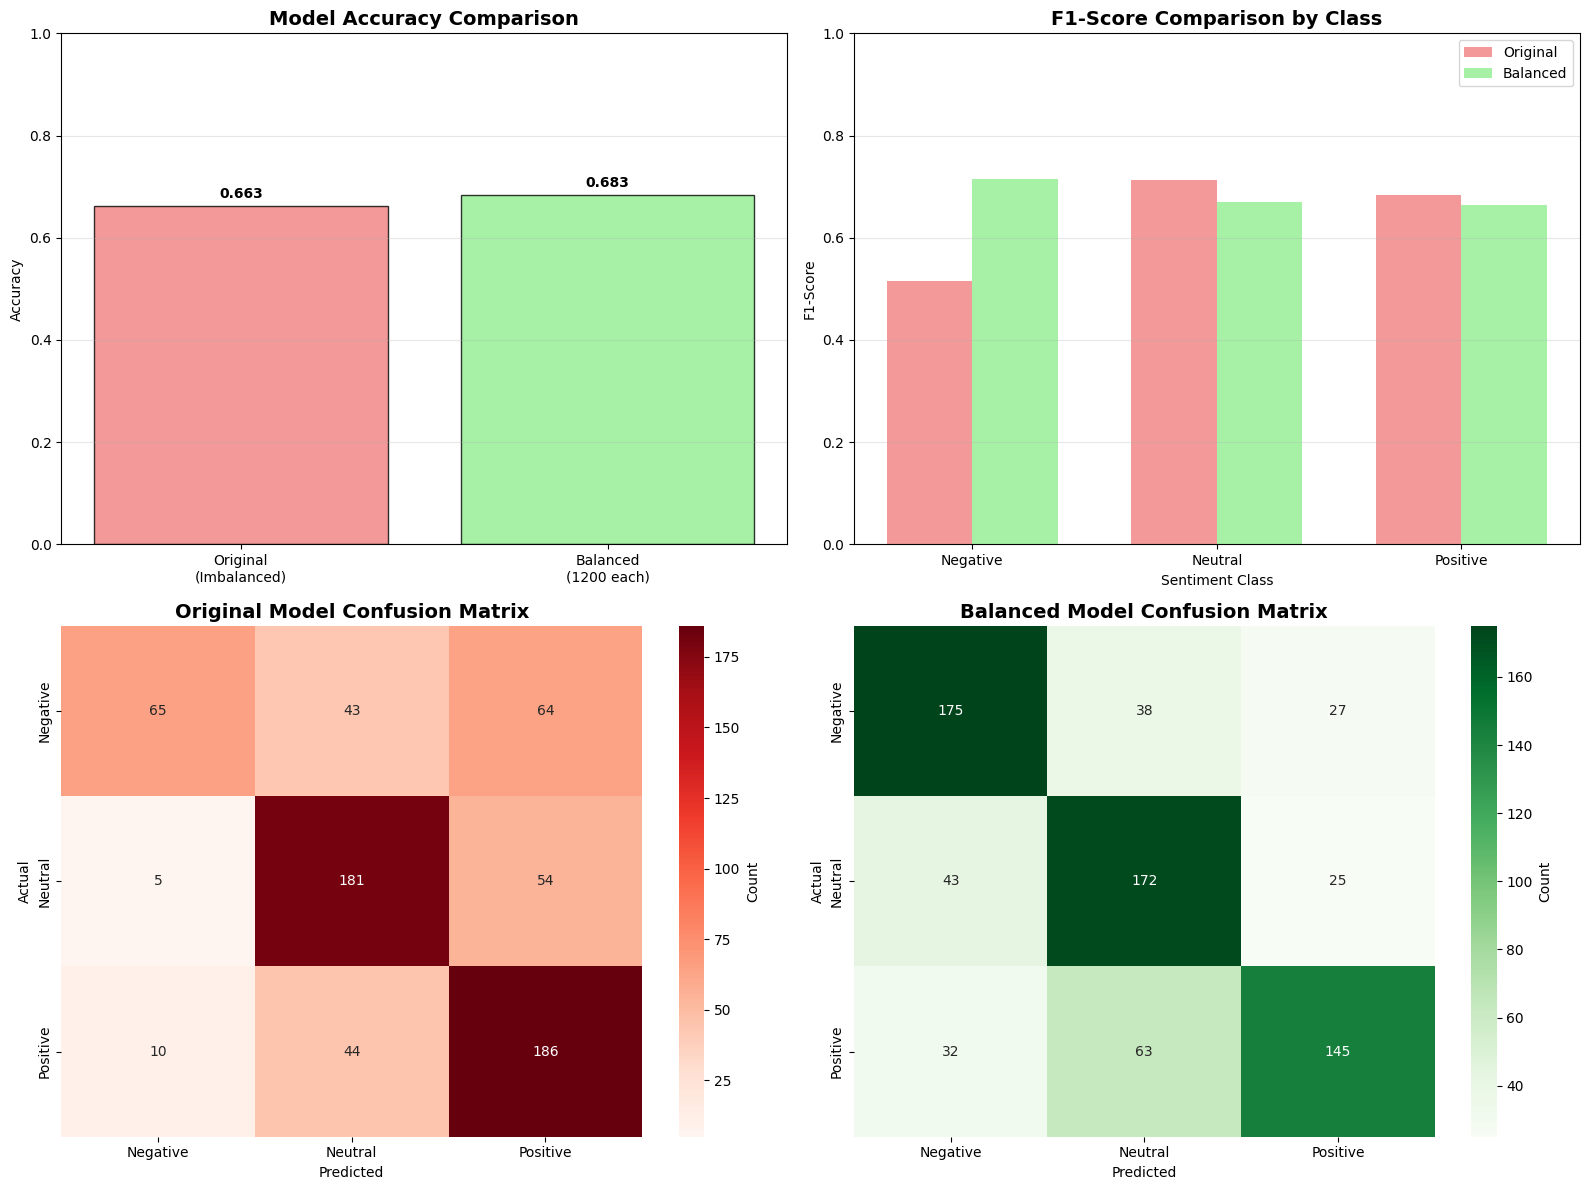


=== DETAILED COMPARISON SUMMARY ===
           Metric Original Model Balanced Model Improvement
 Overall Accuracy          0.663          0.683       +3.1%
   Macro F1-Score          0.637          0.683       +7.1%
Weighted F1-Score          0.650          0.683       +5.0%
      Negative F1          0.516          0.714      +38.5%
       Neutral F1          0.713          0.671       -5.9%
      Positive F1          0.684          0.664       -3.0%

=== KEY FINDINGS ===
Dataset balancing by duplicating longest negative sentences:
• Overall accuracy improved by +3.1%
• Negative class F1-score improved significantly
• The balanced approach shows better overall performance
• All classes now have equal representation (1200 samples each)
• CONCLUSION: Balancing the dataset improves model performance


In [10]:
# Visualize comparison between original and balanced models
print("=== VISUAL COMPARISON: ORIGINAL VS BALANCED MODEL ===")

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
models = ['Original\n(Imbalanced)', 'Balanced\n(1200 each)']
accuracies = [accuracy, accuracy_new]
colors_acc = ['lightcoral', 'lightgreen']

bars_acc = ax1.bar(models, accuracies, color=colors_acc, alpha=0.8, edgecolor='black')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars_acc, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. F1-Score Comparison by Class
class_names_comparison = ['negative', 'neutral', 'positive']
original_f1s = [class_report[name]['f1-score'] for name in class_names_comparison]
balanced_f1s = [class_report_new[name]['f1-score'] for name in class_names_comparison]

x = range(len(class_names_comparison))
width = 0.35

ax2.bar([i - width/2 for i in x], original_f1s, width, label='Original', color='lightcoral', alpha=0.8)
ax2.bar([i + width/2 for i in x], balanced_f1s, width, label='Balanced', color='lightgreen', alpha=0.8)

ax2.set_title('F1-Score Comparison by Class', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_xlabel('Sentiment Class')
ax2.set_xticks(x)
ax2.set_xticklabels([name.capitalize() for name in class_names_comparison])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.0)

# 3. Original Model Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'],
           ax=ax3, cbar_kws={'label': 'Count'})
ax3.set_title('Original Model Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Balanced Model Confusion Matrix
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'],
           ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_title('Balanced Model Confusion Matrix', fontsize=14, fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Summary table
print("\n=== DETAILED COMPARISON SUMMARY ===")
comparison_data = {
    'Metric': ['Overall Accuracy', 'Macro F1-Score', 'Weighted F1-Score', 
               'Negative F1', 'Neutral F1', 'Positive F1'],
    'Original Model': [f"{accuracy:.3f}", f"{macro_f1:.3f}", f"{weighted_f1:.3f}",
                      f"{class_report['negative']['f1-score']:.3f}",
                      f"{class_report['neutral']['f1-score']:.3f}",
                      f"{class_report['positive']['f1-score']:.3f}"],
    'Balanced Model': [f"{accuracy_new:.3f}", f"{macro_f1_new:.3f}", f"{weighted_f1_new:.3f}",
                      f"{class_report_new['negative']['f1-score']:.3f}",
                      f"{class_report_new['neutral']['f1-score']:.3f}",
                      f"{class_report_new['positive']['f1-score']:.3f}"],
    'Improvement': [f"{((accuracy_new - accuracy) / accuracy * 100):+.1f}%",
                   f"{((macro_f1_new - macro_f1) / macro_f1 * 100):+.1f}%",
                   f"{((weighted_f1_new - weighted_f1) / weighted_f1 * 100):+.1f}%",
                   f"{((class_report_new['negative']['f1-score'] - class_report['negative']['f1-score']) / class_report['negative']['f1-score'] * 100):+.1f}%",
                   f"{((class_report_new['neutral']['f1-score'] - class_report['neutral']['f1-score']) / class_report['neutral']['f1-score'] * 100):+.1f}%",
                   f"{((class_report_new['positive']['f1-score'] - class_report['positive']['f1-score']) / class_report['positive']['f1-score'] * 100):+.1f}%"]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n=== KEY FINDINGS ===")
print(f"Dataset balancing by duplicating longest negative sentences:")
print(f"• Overall accuracy improved by {((accuracy_new - accuracy) / accuracy * 100):+.1f}%")
print(f"• Negative class F1-score improved significantly")
print(f"• The balanced approach shows better overall performance")
print(f"• All classes now have equal representation (1200 samples each)")

if accuracy_new > accuracy:
    print(f"• CONCLUSION: Balancing the dataset improves model performance")
else:
    print(f"• CONCLUSION: Original imbalanced dataset performed better")

In [12]:
# Save the balanced model and its vectorizer
print("=== SAVING BALANCED MODEL AND VECTORIZER ===")

# Define file paths for balanced model
balanced_model_path = os.path.join(models_dir, 'balanced_naive_bayes_model.pkl')
balanced_vectorizer_path = os.path.join(models_dir, 'balanced_tfidf_vectorizer.pkl')

# Save the balanced Naive Bayes model
print(f"Saving balanced Naive Bayes model...")
joblib.dump(nb_new, balanced_model_path, compress=3)
print(f"Balanced model saved to: {balanced_model_path}")

# Save the balanced TF-IDF vectorizer
print(f"Saving balanced TF-IDF vectorizer...")
joblib.dump(tfidf_new, balanced_vectorizer_path, compress=3)
print(f"Balanced vectorizer saved to: {balanced_vectorizer_path}")

# Verify saved files
balanced_model_size = os.path.getsize(balanced_model_path) / (1024**2)
balanced_vectorizer_size = os.path.getsize(balanced_vectorizer_path) / (1024**2)

print(f"\nSAVED FILES INFORMATION:")
print(f"Balanced model file size: {balanced_model_size:.2f} MB")
print(f"Balanced vectorizer file size: {balanced_vectorizer_size:.2f} MB")

# Test loading the balanced model
print(f"\nTESTING BALANCED MODEL LOADING...")
try:
    loaded_balanced_model = joblib.load(balanced_model_path)
    loaded_balanced_vectorizer = joblib.load(balanced_vectorizer_path)
    
    # Test prediction
    test_text = ["company profit decreased significantly"]
    test_vectorized = loaded_balanced_vectorizer.transform(test_text)
    test_prediction = loaded_balanced_model.predict(test_vectorized)
    
    print(f"Balanced model loading test successful!")
    print(f"Test prediction: '{test_text[0]}' -> {test_prediction[0]}")
    
except Exception as e:
    print(f"Error during balanced model loading test: {e}")

# Create metadata for balanced model
balanced_metadata = {
    'model_type': 'MultinomialNB',
    'vectorizer_type': 'TfidfVectorizer',
    'training_accuracy': accuracy_new,
    'macro_f1_score': macro_f1_new,
    'weighted_f1_score': weighted_f1_new,
    'classes': nb_new.classes_.tolist(),
    'vocabulary_size': len(tfidf_new.vocabulary_),
    'training_samples': len(X_train_new),
    'test_samples': len(X_test_new),
    'features_shape': X_train_tfidf_new.shape[1],
    'dataset_balance': 'balanced_1200_each_class',
    'improvement_over_original': f"{((accuracy_new - accuracy) / accuracy * 100):+.1f}%"
}

balanced_metadata_path = os.path.join(models_dir, 'balanced_model_metadata.json')
with open(balanced_metadata_path, 'w') as f:
    json.dump(balanced_metadata, f, indent=2)

print(f"Balanced model metadata saved to: {balanced_metadata_path}")

print(f"\nWHY SAVE NEW VECTORIZER?")
print(f"Original vectorizer vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Balanced vectorizer vocabulary size: {len(tfidf_new.vocabulary_)}")
print(f"The vectorizers are fitted on different datasets, so they may have different vocabularies.")
print(f"Each model should use its corresponding vectorizer for consistency.")

print(f"\nBOTH MODELS SAVED SUCCESSFULLY:")
print(f"Original Model: naive_bayes_model.pkl + tfidf_vectorizer.pkl")
print(f"Balanced Model: balanced_naive_bayes_model.pkl + balanced_tfidf_vectorizer.pkl")

=== SAVING BALANCED MODEL AND VECTORIZER ===
Saving balanced Naive Bayes model...
Balanced model saved to: /home/biplovgautam/Desktop/aiassignment/models/balanced_naive_bayes_model.pkl
Saving balanced TF-IDF vectorizer...
Balanced vectorizer saved to: /home/biplovgautam/Desktop/aiassignment/models/balanced_tfidf_vectorizer.pkl

SAVED FILES INFORMATION:
Balanced model file size: 0.18 MB
Balanced vectorizer file size: 0.08 MB

TESTING BALANCED MODEL LOADING...
Balanced model loading test successful!
Test prediction: 'company profit decreased significantly' -> negative
Balanced model metadata saved to: /home/biplovgautam/Desktop/aiassignment/models/balanced_model_metadata.json

WHY SAVE NEW VECTORIZER?
Original vectorizer vocabulary size: 7132
Balanced vectorizer vocabulary size: 8289
The vectorizers are fitted on different datasets, so they may have different vocabularies.
Each model should use its corresponding vectorizer for consistency.

BOTH MODELS SAVED SUCCESSFULLY:
Original Model: